In [ ]:
import pandas as pd
df=pd.read_csv('/content/df.csv')

✅ GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Episode 1/10 | Final Value: $7296.31 | Total Reward: $-2703.69 | Epsilon: 0.3820
Episode 2/10 | Final Value: $11831.28 | Total Reward: $1831.28 | Epsilon: 0.1409
Episode 3/10 | Final Value: $12062.88 | Total Reward: $2062.88 | Epsilon: 0.0520
Episode 4/10 | Final Value: $13256.10 | Total Reward: $3256.10 | Epsilon: 0.0192
Episode 5/10 | Final Value: $14141.48 | Total Reward: $4141.48 | Epsilon: 0.0100
Episode 6/10 | Final Value: $11147.15 | Total Reward: $1147.15 | Epsilon: 0.0100
Episode 7/10 | Final Value: $13921.05 | Total Reward: $3921.05 | Epsilon: 0.0100
Episode 8/10 | Final Value: $9156.74 | Total Reward: $-843.26 | Epsilon: 0.0100
Episode 9/10 | Final Value: $13950.68 | Total Reward: $3950.68 | Epsilon: 0.0100
Episode 10/10 | Final Value: $13444.82 | Total Reward: $3444.82 | Epsilon: 0.0100

📊 Final Results after Training DQN Agent:

Final Capital (average): $12020.85
Cumulative Return      :

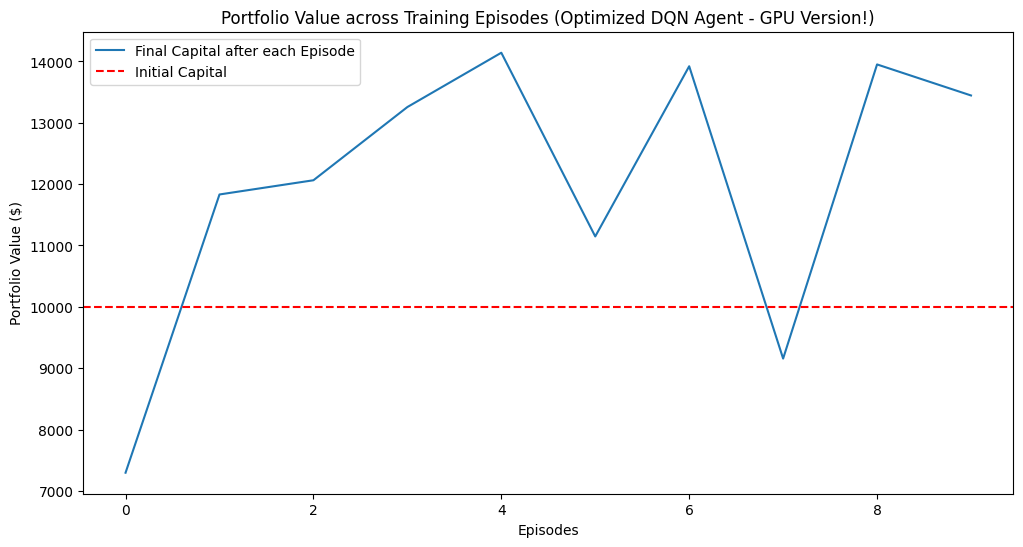

In [ ]:
# ==================================================
# 💻 GPU CONFIGURATION (Google Colab / GPU)
# ==================================================
import tensorflow as tf

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enables memory growth (avoids GPU RAM errors for large jobs)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) available: {gpus}")
    except RuntimeError as e:
        print(f"❌ GPU error: {e}")
else:
    print("⚠️ No GPU found. Will use CPU.")

# ==================================================
# 🐍 IMPORTS
# ==================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# ==================================================
# 🗄️ ASSUMPTION: df is preloaded
# ==================================================
features = ['Open','High','Low','Close','MA7','MA21','daily_sentiment_score']
state_dim = len(features)

scaler = MinMaxScaler()
states = scaler.fit_transform(df[features])
prices = df['Close'].values
n_samples = len(df)

# ==================================================
# 🎯 TRADING ENVIRONMENT CONFIG
# ==================================================
initial_capital = 10000
transaction_cost = 0.001
n_episodes = 10
batch_size = 64
action_size = 3
train_interval = 10
target_update_freq = 2

# ==================================================
# 🧳 REPLAY BUFFER
# ==================================================
class ReplayBuffer:
    def __init__(self, state_dim, action_size, size=10000):
        self.obs1_buf = np.zeros([size, state_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, state_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.uint8)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.uint8)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            "s": self.obs1_buf[idxs],
            "s2": self.obs2_buf[idxs],
            "a": self.acts_buf[idxs],
            "r": self.rews_buf[idxs],
            "d": self.done_buf[idxs]
        }

# ==================================================
# 🕹️ BUILD NEURAL NETWORK
# ==================================================
def build_model(input_dim, action_size, hidden_dim=64, n_hidden_layers=2):
    """Q Network Model"""
    i = Input(shape=(input_dim,))
    x = i
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)
    x = Dense(action_size)(x)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# ==================================================
# 👔 DQN AGENT DEFINITION
# ==================================================
class DQNAgent:
    """ DQN Agent with Target Network """
    def __init__(self, state_size, action_size, gamma=0.9,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=10000)
        self.gamma = gamma
        self.epsilon = epsilon           # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.update_target_model()

    def update_target_model(self):
        """Update Target Model Parameters"""
        self.target_model.set_weights(self.model.get_weights())

    def update_replay_memory(self, state, action, reward, next_state, done):
        """Store Experience"""
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        """Epsilon-greedy Action"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Exploration
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        """Train from Replay Buffer"""
        if self.memory.size < batch_size:
            return
        batch = self.memory.sample_batch(batch_size)

        states = batch["s"]
        next_states = batch["s2"]
        actions = batch["a"]
        rewards = batch["r"]
        done = batch["d"]

        # Target Q-values
        next_q_values = self.target_model.predict(next_states, verbose=0)
        target_q_values = self.model.predict(states, verbose=0)

        for i in range(batch_size):
            target_q_values[i, actions[i]] = rewards[i] + (1-done[i]) * self.gamma * np.max(next_q_values[i])

        # Train
        self.model.train_on_batch(states, target_q_values)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ==================================================
# 🚂 TRAINING LOOP
# ==================================================
agent = DQNAgent(state_dim, action_size)

portfolio_values = []
all_rewards = []
all_dates = df.index

for episode in range(n_episodes):
    balance = initial_capital
    holdings = 0
    total_rewards = 0

    for t in range(n_samples-1):  # leave room for next state
        state = states[t]
        next_state = states[t + 1]
        price = prices[t]
        next_price = prices[t + 1]

        state_reshaped = state.reshape(1, -1)

        # Choose action
        action = agent.act(state_reshaped)

        prev_value = balance + holdings * price

        if action == 2:  # Buy
            quantity = balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                balance -= cost
                holdings += quantity
        elif action == 0:  # Sell
            if holdings > 0:
                revenue = holdings * price * (1 - transaction_cost)
                balance += revenue
                holdings = 0

        new_value = balance + holdings * next_price
        reward = new_value - prev_value
        done = (t == (n_samples - 2))

        # Store experience
        agent.update_replay_memory(state, action, reward, next_state, done)

        total_rewards += reward

        # Train every N steps
        if t % train_interval == 0:
            agent.replay(batch_size)

    # Final episode value
    final_episode_value = balance + holdings * prices[-1]
    portfolio_values.append(final_episode_value)
    all_rewards.append(total_rewards)

    print(f"Episode {episode + 1}/{n_episodes} | Final Value: ${final_episode_value:.2f} | Total Reward: ${total_rewards:.2f} | Epsilon: {agent.epsilon:.4f}")

    # Update Target Network periodically
    if (episode + 1) % target_update_freq == 0:
        agent.update_target_model()

# ==================================================
# ✅ EVALUATION METRICS
# ==================================================
final_capitals = portfolio_values
cumulative_return = (np.mean(final_capitals) / initial_capital) - 1
average_return = np.mean(final_capitals) - initial_capital
volatility = np.std(final_capitals)
sharpe_ratio = average_return / (volatility + 1e-9)

# ==================================================
# 📊 PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training DQN Agent:\n")
print(f"Final Capital (average): ${np.mean(final_capitals):.2f}")
print(f"Cumulative Return      : {cumulative_return * 100:.2f}%")
print(f"Average Profit/Loss    : ${average_return:.2f}")
print(f"Volatility             : ${volatility:.2f}")
print(f"Sharpe Ratio           : {sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Final Capital after each Episode")
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value across Training Episodes (Optimized DQN Agent - GPU Version!)")
plt.show()


Episode 1/5 | Train Final: $10000.00, Test Final: $9708.93 | Train Reward: 0.0000, Test Reward: -0.0206 | Epsilon: 0.6274
✅ New Best Model Saved with Final Test Value: $9708.93
Episode 2/5 | Train Final: $10000.00, Test Final: $8629.76 | Train Reward: 0.0000, Test Reward: -0.1301 | Epsilon: 0.3801


Episode 3/5 | Train Final: $10000.00, Test Final: $10851.73 | Train Reward: 0.0000, Test Reward: 0.1005 | Epsilon: 0.2302
✅ New Best Model Saved with Final Test Value: $10851.73
Episode 4/5 | Train Final: $10000.00, Test Final: $8986.09 | Train Reward: 0.0000, Test Reward: -0.1041 | Epsilon: 0.1395
Episode 5/5 | Train Final: $10000.00, Test Final: $10462.32 | Train Reward: 0.0000, Test Reward: 0.0519 | Epsilon: 0.0845

📊 Final Results after Training DQN Agent:

Train Final Capital (average): $10000.00
Train Cumulative Return      : 0.00%
Train Average Profit/Loss    : $0.00
Train Sharpe Ratio           : 0.0000
Test Final Capital (average): $9727.77
Test Cumulative Return       : -2.72%
Test Average Profit/Loss     : $-272.23
Test Sharpe Ratio            : -0.3227


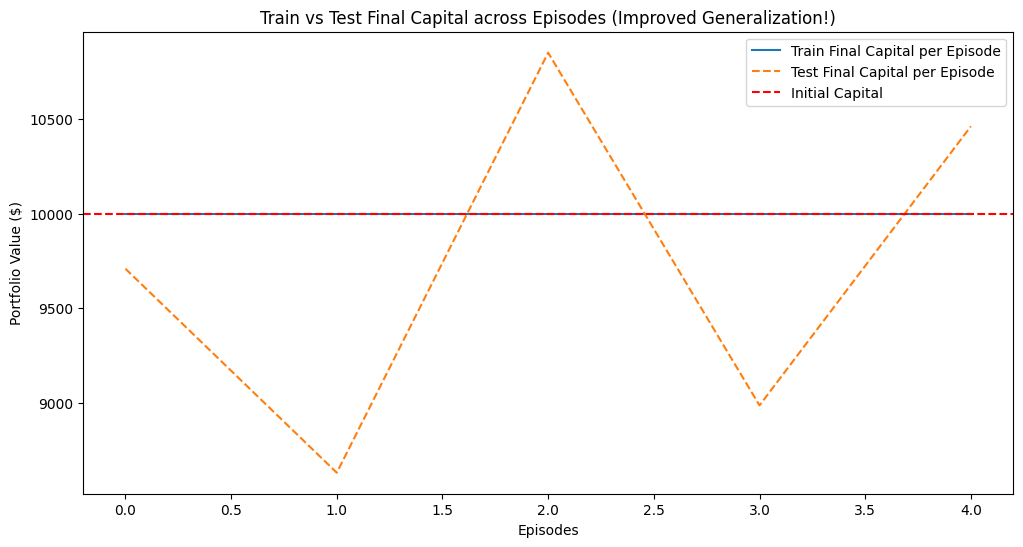

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import copy

# ==================================================
# 🐍 TRAIN / TEST SPLIT
# ==================================================
train_split = int(0.8 * len(df))
train_states = states[:train_split]
train_prices = prices[:train_split]
test_states = states[train_split:]
test_prices = prices[train_split:]

# ==================================================
# 🕹️ UPDATED BUILD MODEL FUNCTION
# ==================================================
def build_model(input_dim, action_size, hidden_dim=32, n_hidden_layers=1, l2_reg=1e-4, dropout_rate=0.1):
    """Q Network Model with Dropout and L2 Regularization"""
    i = Input(shape=(input_dim,))
    x = i
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu', kernel_regularizer=l2(l2_reg))(x)
        x = Dropout(dropout_rate)(x)
    x = Dense(action_size)(x)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# ==================================================
# 👔 UPDATED AGENT INIT
# ==================================================
agent = DQNAgent(state_dim, action_size)

# ==================================================
# 🚂 TRAINING LOOP
# ==================================================
import os
os.makedirs('./models', exist_ok=True)

portfolio_values_train = []
all_rewards_train = []
portfolio_values_test = []
all_rewards_test = []
best_test_score = -np.inf
best_model_weights = None

max_episode_len = 1000  # Random chunk length
for episode in range(n_episodes):
    # Random starting point
    start = np.random.randint(0, len(train_states) - max_episode_len)
    end = start + max_episode_len
    episode_states = train_states[start:end]
    episode_prices = train_prices[start:end]

    balance = initial_capital
    holdings = 0
    total_rewards = 0

    for t in range(len(episode_states) - 1):
        state = episode_states[t]
        next_state = episode_states[t + 1]
        price = episode_prices[t]
        next_price = episode_prices[t + 1]

        state_reshaped = state.reshape(1, -1)
        action = agent.act(state_reshaped)

        prev_value = balance + holdings * price

        # Action execution
        if action == 2:  # Buy
            quantity = balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                balance -= cost
                holdings += quantity
        elif action == 0:  # Sell
            if holdings > 0:
                revenue = holdings * price * (1 - transaction_cost)
                balance += revenue
                holdings = 0

        new_value = balance + holdings * next_price
        reward = (new_value - prev_value) / prev_value  # Normalized reward
        done = (t == len(episode_states) - 2)

        agent.update_replay_memory(state, action, reward, next_state, done)

        total_rewards += reward

        # Training
        if t % train_interval == 0:
            agent.replay(batch_size)

    final_episode_value = balance + holdings * episode_prices[-1]
    portfolio_values_train.append(final_episode_value)
    all_rewards_train.append(total_rewards)

    # ===========================
    # ✅ TEST THE AGENT
    # ===========================
    test_balance = initial_capital
    test_holdings = 0
    test_total_rewards = 0
    for t in range(len(test_states) - 1):
        state = test_states[t].reshape(1, -1)
        action = agent.act(state)  # Exploitation
        price = test_prices[t]
        next_price = test_prices[t + 1]

        prev_value = test_balance + test_holdings * price
        if action == 2:
            quantity = test_balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                test_balance -= cost
                test_holdings += quantity
        elif action == 0:
            if test_holdings > 0:
                revenue = test_holdings * price * (1 - transaction_cost)
                test_balance += revenue
                test_holdings = 0
        test_new_value = test_balance + test_holdings * next_price
        test_total_rewards += (test_new_value - prev_value) / prev_value

    final_test_value = test_balance + test_holdings * test_prices[-1]
    portfolio_values_test.append(final_test_value)
    all_rewards_test.append(test_total_rewards)

    print(f"Episode {episode + 1}/{n_episodes} | "
          f"Train Final: ${final_episode_value:.2f}, Test Final: ${final_test_value:.2f} | "
          f"Train Reward: {total_rewards:.4f}, Test Reward: {test_total_rewards:.4f} | "
          f"Epsilon: {agent.epsilon:.4f}")

    # Save best model
    if final_test_value > best_test_score:
        best_test_score = final_test_value
        best_model_weights = copy.deepcopy(agent.model.get_weights())
        agent.model.save('./models/best_model.h5')
        print(f"✅ New Best Model Saved with Final Test Value: ${final_test_value:.2f}")

    # Target network update
    if (episode + 1) % target_update_freq == 0:
        agent.update_target_model()

# ==================================================
# ✅ EVALUATION METRICS
# ==================================================
train_cumulative_return = (np.mean(portfolio_values_train) / initial_capital) - 1
test_cumulative_return = (np.mean(portfolio_values_test) / initial_capital) - 1

train_average_return = np.mean(portfolio_values_train) - initial_capital
test_average_return = np.mean(portfolio_values_test) - initial_capital

train_volatility = np.std(portfolio_values_train)
test_volatility = np.std(portfolio_values_test)

train_sharpe_ratio = train_average_return / (train_volatility + 1e-9)
test_sharpe_ratio = test_average_return / (test_volatility + 1e-9)

# ==================================================
# 📊 PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training DQN Agent:\n")
print(f"Train Final Capital (average): ${np.mean(portfolio_values_train):.2f}")
print(f"Train Cumulative Return      : {train_cumulative_return * 100:.2f}%")
print(f"Train Average Profit/Loss    : ${train_average_return:.2f}")
print(f"Train Sharpe Ratio           : {train_sharpe_ratio:.4f}")

print(f"Test Final Capital (average): ${np.mean(portfolio_values_test):.2f}")
print(f"Test Cumulative Return       : {test_cumulative_return * 100:.2f}%")
print(f"Test Average Profit/Loss     : ${test_average_return:.2f}")
print(f"Test Sharpe Ratio            : {test_sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_train, label="Train Final Capital per Episode")
plt.plot(portfolio_values_test, label="Test Final Capital per Episode", linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Train vs Test Final Capital across Episodes (Improved Generalization!)")
plt.show()


Episode 1/10 | Train Final: $10000.00, Test Final: $11854.61 | Train Reward: 0.0000, Test Reward: 0.2563 | Epsilon: 0.0100
✅ New Best Model Saved with Final Test Value: $11854.61
Episode 2/10 | Train Final: $10000.00, Test Final: $11816.02 | Train Reward: 0.0000, Test Reward: 0.2544 | Epsilon: 0.0100


Episode 3/10 | Train Final: $10000.00, Test Final: $11909.64 | Train Reward: 0.0000, Test Reward: 0.2605 | Epsilon: 0.0100
✅ New Best Model Saved with Final Test Value: $11909.64


Episode 4/10 | Train Final: $10000.00, Test Final: $11987.58 | Train Reward: 0.0000, Test Reward: 0.2673 | Epsilon: 0.0100
✅ New Best Model Saved with Final Test Value: $11987.58
Episode 5/10 | Train Final: $10000.00, Test Final: $11839.77 | Train Reward: 0.0000, Test Reward: 0.2559 | Epsilon: 0.0100
Episode 6/10 | Train Final: $10000.00, Test Final: $11816.02 | Train Reward: 0.0000, Test Reward: 0.2544 | Epsilon: 0.0100
Episode 7/10 | Train Final: $10000.00, Test Final: $11875.49 | Train Reward: 0.0000, Test Reward: 0.2323 | Epsilon: 0.0100
Episode 8/10 | Train Final: $10000.00, Test Final: $7876.86 | Train Reward: 0.0000, Test Reward: -0.2289 | Epsilon: 0.0100


Episode 9/10 | Train Final: $10000.00, Test Final: $12937.37 | Train Reward: 0.0000, Test Reward: 0.3007 | Epsilon: 0.0100
✅ New Best Model Saved with Final Test Value: $12937.37
Episode 10/10 | Train Final: $10000.00, Test Final: $6801.00 | Train Reward: 0.0000, Test Reward: -0.3647 | Epsilon: 0.0100

📊 Final Results after Training DQN Agent:

Train Final Capital (average): $10000.00
Train Cumulative Return      : 0.00%
Train Average Profit/Loss    : $0.00
Train Sharpe Ratio           : 0.0000
Test Final Capital (average): $11071.44
Test Cumulative Return       : 10.71%
Test Average Profit/Loss     : $1071.44
Test Sharpe Ratio            : 0.5614


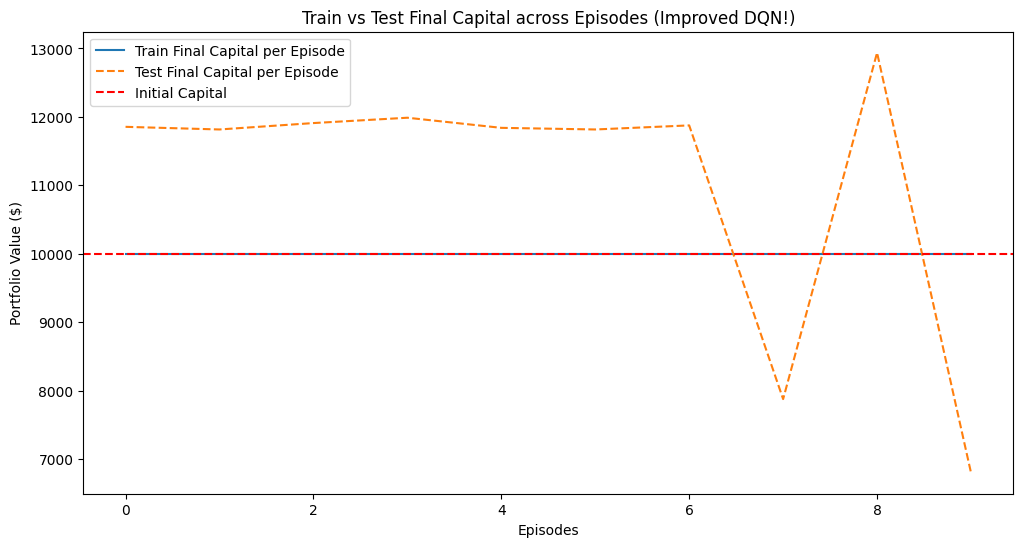

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import os

# ==================================================
# 🐍 TRAIN / TEST SPLIT
# ==================================================
train_split = int(0.8 * len(df))
train_states = states[:train_split]
train_prices = prices[:train_split]
test_states = states[train_split:]
test_prices = prices[train_split:]

state_dim = train_states.shape[1]
action_size = 3
initial_capital = 10000
transaction_cost = 0.001
n_episodes = 10
batch_size = 32
target_update_freq = 5
train_interval = 1

# ==================================================
# 🕹️ BUILD MODEL FUNCTION (With Dropout Only!)
# ==================================================
def build_model(input_dim, action_size, hidden_dim=32, n_hidden_layers=3, dropout_rate=0.1):
    """Q Network Model with Dropout Regularization"""
    i = Input(shape=(input_dim,))
    x = i
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    x = Dense(action_size)(x)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# ==================================================
# 🧳 REPLAY BUFFER
# ==================================================
class ReplayBuffer:
    def __init__(self, state_dim, action_size, size=10000):
        self.obs1_buf = np.zeros([size, state_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, state_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.uint8)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.uint8)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            "s": self.obs1_buf[idxs],
            "s2": self.obs2_buf[idxs],
            "a": self.acts_buf[idxs],
            "r": self.rews_buf[idxs],
            "d": self.done_buf[idxs]
        }

# ==================================================
# 👔 DQN AGENT DEFINITION
# ==================================================
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=10000)
        self.gamma = gamma
        self.epsilon = epsilon           # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.update_target_model()

    def update_target_model(self):
        """Update Target Model Weights"""
        self.target_model.set_weights(self.model.get_weights())

    def update_replay_memory(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        """Epsilon-greedy action"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        """Train the network from replay buffer"""
        if self.memory.size < batch_size:
            return
        batch = self.memory.sample_batch(batch_size)
        states = batch["s"]
        next_states = batch["s2"]
        actions = batch["a"]
        rewards = batch["r"]
        done = batch["d"]

        target_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            target_q_values[i, actions[i]] = rewards[i] + (1-done[i]) * self.gamma * np.max(next_q_values[i])

        self.model.train_on_batch(states, target_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ==================================================
# 🚂 TRAINING LOOP
# ==================================================
os.makedirs('./models', exist_ok=True)

agent = DQNAgent(state_dim, action_size)

portfolio_values_train = []
all_rewards_train = []
portfolio_values_test = []
all_rewards_test = []
best_test_score = -np.inf
best_model_weights = None

max_episode_len = 1000
for episode in range(n_episodes):
    # Training
    balance = initial_capital
    holdings = 0
    total_rewards = 0

    start = np.random.randint(0, len(train_states) - max_episode_len)
    end = start + max_episode_len
    episode_states = train_states[start:end]
    episode_prices = train_prices[start:end]

    for t in range(len(episode_states) - 1):
        state = episode_states[t]
        next_state = episode_states[t + 1]
        price = episode_prices[t]
        next_price = episode_prices[t + 1]

        state_reshaped = state.reshape(1, -1)
        action = agent.act(state_reshaped)

        prev_value = balance + holdings * price
        if action == 2:  # Buy
            quantity = balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                balance -= cost
                holdings += quantity
        elif action == 0:  # Sell
            if holdings > 0:
                revenue = holdings * price * (1 - transaction_cost)
                balance += revenue
                holdings = 0

        new_value = balance + holdings * next_price
        reward = (new_value - prev_value) / prev_value
        done = (t == len(episode_states) - 2)

        agent.update_replay_memory(state, action, reward, next_state, done)

        total_rewards += reward

        if t % train_interval == 0:
            agent.replay(batch_size)

    final_episode_value = balance + holdings * episode_prices[-1]
    portfolio_values_train.append(final_episode_value)
    all_rewards_train.append(total_rewards)

    # Testing
    test_balance = initial_capital
    test_holdings = 0
    test_total_rewards = 0
    for t in range(len(test_states) - 1):
        state = test_states[t].reshape(1, -1)
        action = agent.act(state)  # Exploitation
        price = test_prices[t]
        next_price = test_prices[t + 1]

        prev_value = test_balance + test_holdings * price
        if action == 2:
            quantity = test_balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                test_balance -= cost
                test_holdings += quantity
        elif action == 0:
            if test_holdings > 0:
                revenue = test_holdings * price * (1 - transaction_cost)
                test_balance += revenue
                test_holdings = 0
        test_new_value = test_balance + test_holdings * next_price
        test_total_rewards += (test_new_value - prev_value) / prev_value

    final_test_value = test_balance + test_holdings * test_prices[-1]
    portfolio_values_test.append(final_test_value)
    all_rewards_test.append(test_total_rewards)

    print(f"Episode {episode + 1}/{n_episodes} | "
          f"Train Final: ${final_episode_value:.2f}, Test Final: ${final_test_value:.2f} | "
          f"Train Reward: {total_rewards:.4f}, Test Reward: {test_total_rewards:.4f} | "
          f"Epsilon: {agent.epsilon:.4f}")

    if final_test_value > best_test_score:
        best_test_score = final_test_value
        best_model_weights = copy.deepcopy(agent.model.get_weights())
        agent.model.save('./models/best_model.h5')
        print(f"✅ New Best Model Saved with Final Test Value: ${final_test_value:.2f}")

    if (episode + 1) % target_update_freq == 0:
        agent.update_target_model()

# ==================================================
# ✅ EVALUATION METRICS
# ==================================================
train_cumulative_return = (np.mean(portfolio_values_train) / initial_capital) - 1
test_cumulative_return = (np.mean(portfolio_values_test) / initial_capital) - 1
train_average_return = np.mean(portfolio_values_train) - initial_capital
test_average_return = np.mean(portfolio_values_test) - initial_capital
train_volatility = np.std(portfolio_values_train)
test_volatility = np.std(portfolio_values_test)

train_sharpe_ratio = train_average_return / (train_volatility + 1e-9)
test_sharpe_ratio = test_average_return / (test_volatility + 1e-9)

# ==================================================
# 📊 PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training DQN Agent:\n")
print(f"Train Final Capital (average): ${np.mean(portfolio_values_train):.2f}")
print(f"Train Cumulative Return      : {train_cumulative_return * 100:.2f}%")
print(f"Train Average Profit/Loss    : ${train_average_return:.2f}")
print(f"Train Sharpe Ratio           : {train_sharpe_ratio:.4f}")

print(f"Test Final Capital (average): ${np.mean(portfolio_values_test):.2f}")
print(f"Test Cumulative Return       : {test_cumulative_return * 100:.2f}%")
print(f"Test Average Profit/Loss     : ${test_average_return:.2f}")
print(f"Test Sharpe Ratio            : {test_sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_train, label="Train Final Capital per Episode")
plt.plot(portfolio_values_test, label="Test Final Capital per Episode", linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Train vs Test Final Capital across Episodes (Improved DQN!)")
plt.show()


Episode 1/8 | Train Final: $10000.00, Test Final: $8570.22 | Train Reward: 0.0000, Test Reward: -0.1321 | Epsilon: 0.0324
✅ New Best Model Saved with Final Test Value: $8570.22


Episode 2/8 | Train Final: $10000.00, Test Final: $13550.37 | Train Reward: 0.0000, Test Reward: 0.3253 | Epsilon: 0.0100
✅ New Best Model Saved with Final Test Value: $13550.37
Episode 3/8 | Train Final: $10000.00, Test Final: $11366.49 | Train Reward: 0.0000, Test Reward: 0.1732 | Epsilon: 0.0100
Episode 4/8 | Train Final: $10000.00, Test Final: $11816.02 | Train Reward: 0.0000, Test Reward: 0.2544 | Epsilon: 0.0100
Episode 5/8 | Train Final: $10000.00, Test Final: $7831.47 | Train Reward: 0.0000, Test Reward: -0.2316 | Epsilon: 0.0100
Episode 6/8 | Train Final: $10570.40, Test Final: $11816.01 | Train Reward: 0.0589, Test Reward: 0.2302 | Epsilon: 0.0100
Episode 7/8 | Train Final: $10000.00, Test Final: $10072.13 | Train Reward: 0.0000, Test Reward: 0.0072 | Epsilon: 0.0100
Episode 8/8 | Train Final: $10000.00, Test Final: $10000.00 | Train Reward: 0.0000, Test Reward: 0.0000 | Epsilon: 0.0100

📊 Final Results after Training LSTM-DQN Agent:

Train Final Capital (average): $10071.30


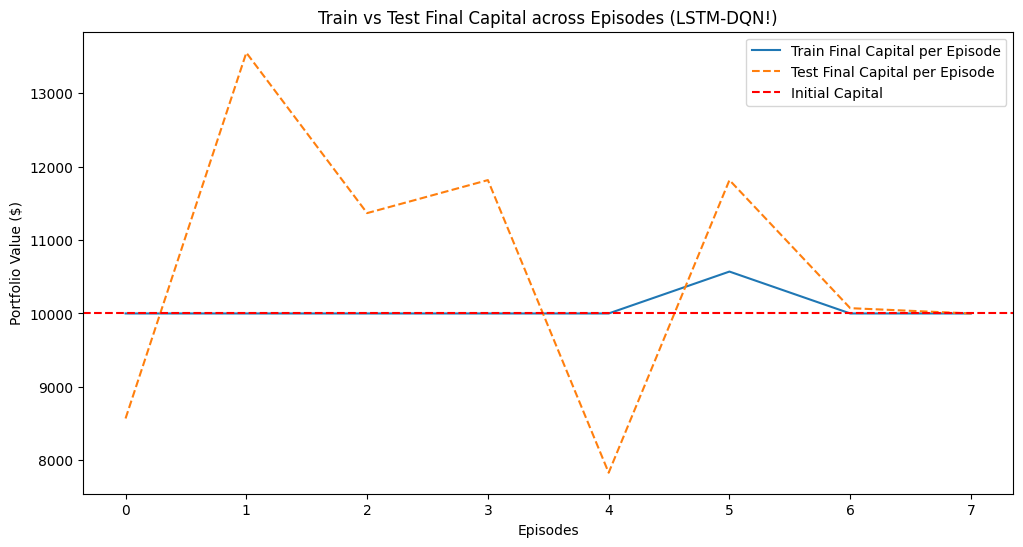

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import os

# ==================================================
# ⚡️ PARAMETERS
# ==================================================
train_split = int(0.8 * len(df))
train_states = states[:train_split]
train_prices = prices[:train_split]
test_states = states[train_split:]
test_prices = prices[train_split:]

state_dim = train_states.shape[1]
action_size = 3
initial_capital = 10000
transaction_cost = 0.001
n_episodes = 8
batch_size = 16
target_update_freq = 5
train_interval = 1
window_size = 10

# ==================================================
# ⚡️ FUNCTION TO CREATE SEQUENCES
# ==================================================
def create_sequences(data, window_size):
    """ Returns array of shape (n_samples, window_size, state_dim) """
    seq = []
    for i in range(len(data) - window_size + 1):
        seq.append(data[i:i + window_size])
    return np.array(seq)

train_states_seq = create_sequences(train_states, window_size)
train_prices_seq = train_prices[window_size-1:]
test_states_seq = create_sequences(test_states, window_size)
test_prices_seq = test_prices[window_size-1:]

# ==================================================
# ⚡️ BUILD LSTM MODEL
# ==================================================
def build_model(window_size, state_dim, action_size, hidden_dim=32, n_hidden_layers=1, dropout_rate=0.1):
    """LSTM Q Network"""
    i = Input(shape=(window_size, state_dim))
    x = LSTM(hidden_dim)(i)
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    x = Dense(action_size)(x)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# ==================================================
# ⚡️ REPLAY BUFFER
# ==================================================
class ReplayBuffer:
    def __init__(self, window_size, state_dim, action_size, size=10000):
        self.obs1_buf = np.zeros([size, window_size, state_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, window_size, state_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.uint8)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.uint8)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            "s": self.obs1_buf[idxs],
            "s2": self.obs2_buf[idxs],
            "a": self.acts_buf[idxs],
            "r": self.rews_buf[idxs],
            "d": self.done_buf[idxs]
        }

# ==================================================
# ⚡️ AGENT DEFINITION
# ==================================================
class DQNAgent:
    def __init__(self, window_size, state_dim, action_size,
                 gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.window_size = window_size
        self.state_dim = state_dim
        self.action_size = action_size
        self.memory = ReplayBuffer(window_size, state_dim, action_size, size=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = build_model(window_size, state_dim, action_size)
        self.target_model = build_model(window_size, state_dim, action_size)
        self.update_target_model()

    def update_target_model(self):
        """Update Target Model Weights"""
        self.target_model.set_weights(self.model.get_weights())

    def update_replay_memory(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):  # state.shape = (1, window_size, state_dim)
        """Epsilon-greedy action"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        """Train the network from replay buffer"""
        if self.memory.size < batch_size:
            return
        batch = self.memory.sample_batch(batch_size)
        states = batch["s"]
        next_states = batch["s2"]
        actions = batch["a"]
        rewards = batch["r"]
        done = batch["d"]

        target_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            target_q_values[i, actions[i]] = rewards[i] + (1-done[i]) * self.gamma * np.max(next_q_values[i])

        self.model.train_on_batch(states, target_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ==================================================
# ⚡️ TRAINING LOOP
# ==================================================
os.makedirs('./models', exist_ok=True)

agent = DQNAgent(window_size, state_dim, action_size)

portfolio_values_train = []
all_rewards_train = []
portfolio_values_test = []
all_rewards_test = []
best_test_score = -np.inf
best_model_weights = None

max_episode_len = min(700 , len(train_states_seq))
for episode in range(n_episodes):
    balance = initial_capital
    holdings = 0
    total_rewards = 0

    start = np.random.randint(0, len(train_states_seq) - max_episode_len)
    end = start + max_episode_len
    episode_states = train_states_seq[start:end]
    episode_prices = train_prices_seq[start:end]

    for t in range(len(episode_states) - 1):
        state = episode_states[t]
        next_state = episode_states[t + 1]
        price = episode_prices[t]
        next_price = episode_prices[t + 1]

        state_reshaped = state.reshape(1, window_size, state_dim)
        action = agent.act(state_reshaped)

        prev_value = balance + holdings * price
        if action == 2:  # Buy
            quantity = balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                balance -= cost
                holdings += quantity
        elif action == 0:  # Sell
            if holdings > 0:
                revenue = holdings * price * (1 - transaction_cost)
                balance += revenue
                holdings = 0

        new_value = balance + holdings * next_price
        reward = (new_value - prev_value) / prev_value
        done = (t == len(episode_states) - 2)

        agent.update_replay_memory(state, action, reward, next_state, done)

        total_rewards += reward
        if t % train_interval == 0:
            agent.replay(batch_size)

    final_episode_value = balance + holdings * episode_prices[-1]
    portfolio_values_train.append(final_episode_value)
    all_rewards_train.append(total_rewards)

    # Testing
    test_balance = initial_capital
    test_holdings = 0
    test_total_rewards = 0
    for t in range(len(test_states_seq) - 1):
        state = test_states_seq[t].reshape(1, window_size, state_dim)
        action = agent.act(state)  # Exploitation
        price = test_prices_seq[t]
        next_price = test_prices_seq[t + 1]

        prev_value = test_balance + test_holdings * price
        if action == 2:
            quantity = test_balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                test_balance -= cost
                test_holdings += quantity
        elif action == 0:
            if test_holdings > 0:
                revenue = test_holdings * price * (1 - transaction_cost)
                test_balance += revenue
                test_holdings = 0
        test_new_value = test_balance + test_holdings * next_price
        test_total_rewards += (test_new_value - prev_value) / prev_value

    final_test_value = test_balance + test_holdings * test_prices_seq[-1]
    portfolio_values_test.append(final_test_value)
    all_rewards_test.append(test_total_rewards)

    print(f"Episode {episode + 1}/{n_episodes} | "
          f"Train Final: ${final_episode_value:.2f}, Test Final: ${final_test_value:.2f} | "
          f"Train Reward: {total_rewards:.4f}, Test Reward: {test_total_rewards:.4f} | "
          f"Epsilon: {agent.epsilon:.4f}")

    if final_test_value > best_test_score:
        best_test_score = final_test_value
        best_model_weights = copy.deepcopy(agent.model.get_weights())
        agent.model.save('./models/best_model.h5')
        print(f"✅ New Best Model Saved with Final Test Value: ${final_test_value:.2f}")

    if (episode + 1) % target_update_freq == 0:
        agent.update_target_model()

# ==================================================
# ✅ EVALUATION METRICS
# ==================================================
train_cumulative_return = (np.mean(portfolio_values_train) / initial_capital) - 1
test_cumulative_return = (np.mean(portfolio_values_test) / initial_capital) - 1
train_average_return = np.mean(portfolio_values_train) - initial_capital
test_average_return = np.mean(portfolio_values_test) - initial_capital
train_volatility = np.std(portfolio_values_train)
test_volatility = np.std(portfolio_values_test)

train_sharpe_ratio = train_average_return / (train_volatility + 1e-9)
test_sharpe_ratio = test_average_return / (test_volatility + 1e-9)

# ==================================================
# 📊 PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training LSTM-DQN Agent:\n")
print(f"Train Final Capital (average): ${np.mean(portfolio_values_train):.2f}")
print(f"Train Cumulative Return      : {train_cumulative_return * 100:.2f}%")
print(f"Train Average Profit/Loss    : ${train_average_return:.2f}")
print(f"Train Sharpe Ratio           : {train_sharpe_ratio:.4f}")

print(f"Test Final Capital (average): ${np.mean(portfolio_values_test):.2f}")
print(f"Test Cumulative Return       : {test_cumulative_return * 100:.2f}%")
print(f"Test Average Profit/Loss     : ${test_average_return:.2f}")
print(f"Test Sharpe Ratio            : {test_sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_train, label="Train Final Capital per Episode")
plt.plot(portfolio_values_test, label="Test Final Capital per Episode", linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Train vs Test Final Capital across Episodes (LSTM-DQN!)")
plt.show()


##LSTM+DQN

Episode 1/10 | Train Final: $10000.00, Test Final: $11923.94 | Train Reward: 0.0000, Test Reward: 0.2617 | Epsilon: 0.0339
✅ New Best Model Saved with Final Test Value: $11923.94
Episode 2/10 | Train Final: $10000.00, Test Final: $10000.00 | Train Reward: 0.0000, Test Reward: 0.0000 | Epsilon: 0.0100
Episode 3/10 | Train Final: $10000.00, Test Final: $10017.30 | Train Reward: 0.0000, Test Reward: 0.0024 | Epsilon: 0.0100
Episode 4/10 | Train Final: $10000.00, Test Final: $10198.48 | Train Reward: 0.0000, Test Reward: 0.0199 | Epsilon: 0.0100
Episode 5/10 | Train Final: $10000.00, Test Final: $10000.00 | Train Reward: 0.0000, Test Reward: 0.0000 | Epsilon: 0.0100
Episode 6/10 | Train Final: $10000.00, Test Final: $11816.02 | Train Reward: 0.0000, Test Reward: 0.2544 | Epsilon: 0.0100
Episode 7/10 | Train Final: $10000.00, Test Final: $10000.00 | Train Reward: 0.0000, Test Reward: 0.0000 | Epsilon: 0.0100
Episode 8/10 | Train Final: $10000.00, Test Final: $11850.48 | Train Reward: 0.0000

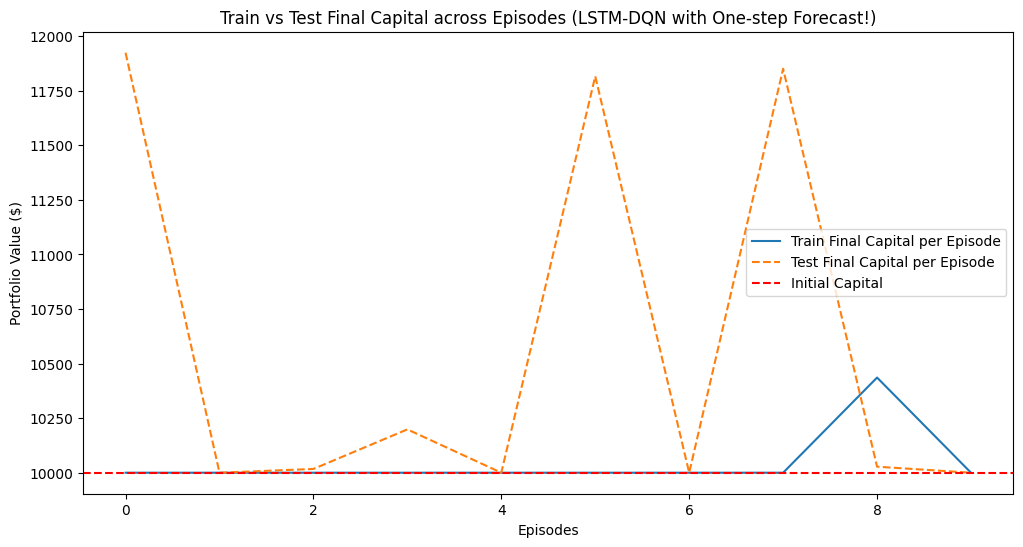

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import os

# ==================================================
# ⚡️ PARAMETERS
# ==================================================
train_split = int(0.8 * len(df))
train_states = states[:train_split]
train_prices = prices[:train_split]
test_states = states[train_split:]
test_prices = prices[train_split:]

state_dim = train_states.shape[1]
action_size = 3
initial_capital = 10000
transaction_cost = 0.001
n_episodes = 10
batch_size = 25
target_update_freq = 5
train_interval = 1
window_size = 10

# ==================================================
# ⚡️ FUNCTION TO CREATE SEQUENCES
# ==================================================
def create_sequences(data, window_size):
    """ Returns array of shape (n_samples, window_size, state_dim) """
    seq = []
    for i in range(len(data) - window_size + 1):
        seq.append(data[i:i + window_size])
    return np.array(seq)

train_states_seq = create_sequences(train_states, window_size)
train_prices_seq = train_prices[window_size-1:]
test_states_seq = create_sequences(test_states, window_size)
test_prices_seq = test_prices[window_size-1:]

# ==================================================
# ⚡️ ONE-STEP FORECAST FUNCTION
# ==================================================
def one_step_forecast(prices, t):  # ✨ MOD
    """Return next price prediction (one-step ahead).
    Here we use the actual next price for simplicity."""
    return prices[t + 1]

# ==================================================
# ⚡️ BUILD MODEL
# ==================================================
def build_model(window_size, state_dim, action_size, hidden_dim=32, n_hidden_layers=1, dropout_rate=0.1):  # ✨ MOD
    """LSTM Q Network expecting state_dim + 1 (for one-step prediction)"""
    i = Input(shape=(window_size, state_dim + 1))
    x = LSTM(hidden_dim)(i)
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    x = Dense(action_size)(x)
    model = Model(i, x)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# ==================================================
# ⚡️ REPLAY BUFFER
# ==================================================
class ReplayBuffer:
    def __init__(self, window_size, state_dim, action_size, size=10000):
        self.obs1_buf = np.zeros([size, window_size, state_dim + 1], dtype=np.float32)  # ✨ MOD
        self.obs2_buf = np.zeros([size, window_size, state_dim + 1], dtype=np.float32)  # ✨ MOD
        self.acts_buf = np.zeros(size, dtype=np.uint8)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.uint8)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            "s": self.obs1_buf[idxs],
            "s2": self.obs2_buf[idxs],
            "a": self.acts_buf[idxs],
            "r": self.rews_buf[idxs],
            "d": self.done_buf[idxs]
        }

# ==================================================
# ⚡️ AGENT DEFINITION
# ==================================================
class DQNAgent:
    def __init__(self, window_size, state_dim, action_size,
                 gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.window_size = window_size
        self.state_dim = state_dim
        self.action_size = action_size
        self.memory = ReplayBuffer(window_size, state_dim, action_size, size=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = build_model(window_size, state_dim, action_size)
        self.target_model = build_model(window_size, state_dim, action_size)
        self.update_target_model()

    def update_target_model(self):
        """Update Target Model Weights"""
        self.target_model.set_weights(self.model.get_weights())

    def update_replay_memory(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):  # state.shape = (1, window_size, state_dim + 1) ✨ MOD
        """Epsilon-greedy action"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        """Train the network from replay buffer"""
        if self.memory.size < batch_size:
            return
        batch = self.memory.sample_batch(batch_size)
        states = batch["s"]
        next_states = batch["s2"]
        actions = batch["a"]
        rewards = batch["r"]
        done = batch["d"]

        target_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            target_q_values[i, actions[i]] = rewards[i] + (1-done[i]) * self.gamma * np.max(next_q_values[i])

        self.model.train_on_batch(states, target_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ==================================================
# ⚡️ TRAINING LOOP
# ==================================================
# ==================================================
# ⚡️ TRAINING LOOP
# ==================================================
os.makedirs('./models', exist_ok=True)

agent = DQNAgent(window_size, state_dim, action_size)

portfolio_values_train = []
all_rewards_train = []
portfolio_values_test = []
all_rewards_test = []
best_test_score = -np.inf
best_model_weights = None

max_episode_len = min(700, len(train_states_seq))
for episode in range(n_episodes):
    balance = initial_capital
    holdings = 0
    total_rewards = 0

    start = np.random.randint(0, len(train_states_seq) - max_episode_len)
    end = start + max_episode_len
    episode_states = train_states_seq[start:end]
    episode_prices = train_prices_seq[start:end]

    # Ensure episode_prices has length at least 2 for one-step lookahead
    if len(episode_prices) < 2:
        print(f"Skipping episode {episode + 1}: Episode length too short.")
        continue

    for t in range(len(episode_states) - 1):
        state = episode_states[t]
        next_state = episode_states[t + 1]
        price = episode_prices[t]
        next_price = episode_prices[t + 1]

        # ✨ MOD: Append one-step forecast
        # The forecast for the current state is the next actual price
        forecast_value = next_price
        # Repeat the forecast value for each time step in the window and reshape
        forecast_column = np.full((window_size, 1), forecast_value)
        # Concatenate the state with the forecast column along the last axis (features)
        state_with_forecast = np.append(state, forecast_column, axis=-1).reshape(1, window_size, state_dim + 1)

        # The forecast for the next state is the price after the next price.
        # This is only possible if t + 2 is within the bounds of episode_prices.
        if t + 2 < len(episode_prices):
            next_forecast_value = episode_prices[t + 2]
        else:
            # For the last step of the episode, there is no price after next_price.
            # We can use the next_price itself as a placeholder or handle this case differently.
            # Using the next_price is a simple approach here.
            next_forecast_value = next_price

        # Repeat the next forecast value similarly for the next state
        next_forecast_column = np.full((window_size, 1), next_forecast_value)
        next_state_with_forecast = np.append(next_state, next_forecast_column, axis=-1)


        action = agent.act(state_with_forecast)

        prev_value = balance + holdings * price
        if action == 2:  # Buy
            quantity = balance // price
            cost = quantity * price * (1 + transaction_cost)
            if quantity > 0:
                balance -= cost
                holdings += quantity
        elif action == 0:  # Sell
            if holdings > 0:
                revenue = holdings * price * (1 - transaction_cost)
                balance += revenue
                holdings = 0

        new_value = balance + holdings * next_price
        reward = (new_value - prev_value) / prev_value
        done = (t == len(episode_states) - 2)

        agent.update_replay_memory(
            state_with_forecast[0], # Pass the state without the batch dimension
            action,
            reward,
            next_state_with_forecast,
            done
        )
        total_rewards += reward
        if t % train_interval == 0:
            agent.replay(batch_size)

    final_episode_value = balance + holdings * episode_prices[-1]
    portfolio_values_train.append(final_episode_value)
    all_rewards_train.append(total_rewards)

    # Testing
    test_balance = initial_capital
    test_holdings = 0
    test_total_rewards = 0
    # Ensure test_prices_seq has length at least 2 for one-step lookahead
    if len(test_prices_seq) < 2:
         print(f"Skipping testing for episode {episode + 1}: Test sequence length too short.")
         final_test_value = initial_capital # Or some other default
         portfolio_values_test.append(final_test_value)
         all_rewards_test.append(0)
    else:
        for t in range(len(test_states_seq) - 1):
            state = test_states_seq[t]
            # next_state = test_states_seq[t + 1] # Although not used in test loop, good practice
            price = test_prices_seq[t]
            next_price = test_prices_seq[t + 1]

            # Append forecast for test state
            # The forecast for the current test state is the next actual price
            test_forecast_value = next_price
            test_forecast_column = np.full((window_size, 1), test_forecast_value)
            state_with_forecast = np.append(state, test_forecast_column, axis=-1).reshape(1, window_size, state_dim + 1)

            action = agent.act(state_with_forecast)  # Exploitation
            prev_value = test_balance + test_holdings * price
            if action == 2:
                quantity = test_balance // price
                cost = quantity * price * (1 + transaction_cost)
                if quantity > 0:
                    test_balance -= cost
                    test_holdings += quantity
            elif action == 0:
                if test_holdings > 0:
                    revenue = test_holdings * price * (1 - transaction_cost)
                    test_balance += revenue
                    test_holdings = 0
            test_new_value = test_balance + test_holdings * next_price
            test_total_rewards += (test_new_value - prev_value) / prev_value

        final_test_value = test_balance + test_holdings * test_prices_seq[-1]
        portfolio_values_test.append(final_test_value)
        all_rewards_test.append(test_total_rewards)

    print(f"Episode {episode + 1}/{n_episodes} | "
          f"Train Final: ${final_episode_value:.2f}, Test Final: ${final_test_value:.2f} | "
          f"Train Reward: {total_rewards:.4f}, Test Reward: {test_total_rewards:.4f} | "
          f"Epsilon: {agent.epsilon:.4f}")

    if final_test_value > best_test_score:
        best_test_score = final_test_value
        best_model_weights = copy.deepcopy(agent.model.get_weights())
        agent.model.save('./models/best_model.h5')
        print(f"✅ New Best Model Saved with Final Test Value: ${final_test_value:.2f}")

    if (episode + 1) % target_update_freq == 0:
        agent.update_target_model()

# ==================================================
# ✅ EVALUATION METRICS
# ==================================================
train_cumulative_return = (np.mean(portfolio_values_train) / initial_capital) - 1
test_cumulative_return = (np.mean(portfolio_values_test) / initial_capital) - 1
train_average_return = np.mean(portfolio_values_train) - initial_capital
test_average_return = np.mean(portfolio_values_test) - initial_capital
train_volatility = np.std(portfolio_values_train)
test_volatility = np.std(portfolio_values_test)

train_sharpe_ratio = train_average_return / (train_volatility + 1e-9)
test_sharpe_ratio = test_average_return / (test_volatility + 1e-9)

# ==================================================
# 📊 PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training LSTM-DQN Agent with One-step Forecast:\n")
print(f"Train Final Capital (average): ${np.mean(portfolio_values_train):.2f}")
print(f"Train Cumulative Return      : {train_cumulative_return * 100:.2f}%")
print(f"Train Average Profit/Loss    : ${train_average_return:.2f}")
print(f"Train Sharpe Ratio           : {train_sharpe_ratio:.4f}")

print(f"Test Final Capital (average): ${np.mean(portfolio_values_test):.2f}")
print(f"Test Cumulative Return       : {test_cumulative_return * 100:.2f}%")
print(f"Test Average Profit/Loss     : ${test_average_return:.2f}")
print(f"Test Sharpe Ratio            : {test_sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_train, label="Train Final Capital per Episode")
plt.plot(portfolio_values_test, label="Test Final Capital per Episode", linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Train vs Test Final Capital across Episodes (LSTM-DQN with One-step Forecast!)")
plt.show()

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'Daily Return', 'MA7', 'MA21', 'finbert_neg_score',
       'finbert_neutral_score', 'finbert_positive_score',
       'daily_sentiment_score', 'Log Close'],
      dtype='object')

## DDPG

Episode 1/10 | Train Final: $10000.00, Test Final: $10000.26 | Train Reward: 0.0000, Test Reward: 0.2642
✅ New Best Model Saved with Final Test Value: $10000.26


Episode 2/10 | Train Final: $10000.00, Test Final: $13385.20 | Train Reward: 0.0000, Test Reward: 3385.2019
✅ New Best Model Saved with Final Test Value: $13385.20
Episode 3/10 | Train Final: $10000.00, Test Final: $11252.84 | Train Reward: 0.0000, Test Reward: 1252.8389
Episode 4/10 | Train Final: $10000.00, Test Final: $11275.61 | Train Reward: 0.0000, Test Reward: 1275.6148
Episode 5/10 | Train Final: $10054.28, Test Final: $11299.85 | Train Reward: 54.2809, Test Reward: 1299.8527
Episode 6/10 | Train Final: $10373.65, Test Final: $11839.93 | Train Reward: 373.6460, Test Reward: 1839.9251
Episode 7/10 | Train Final: $10000.00, Test Final: $11855.25 | Train Reward: 0.0000, Test Reward: 1855.2463
Episode 8/10 | Train Final: $10000.00, Test Final: $11854.40 | Train Reward: 0.0000, Test Reward: 1854.4027
Episode 9/10 | Train Final: $10000.00, Test Final: $11879.56 | Train Reward: 0.0000, Test Reward: 1879.5570
Episode 10/10 | Train Final: $10470.15, Test Final: $11816.02 | Train Reward:

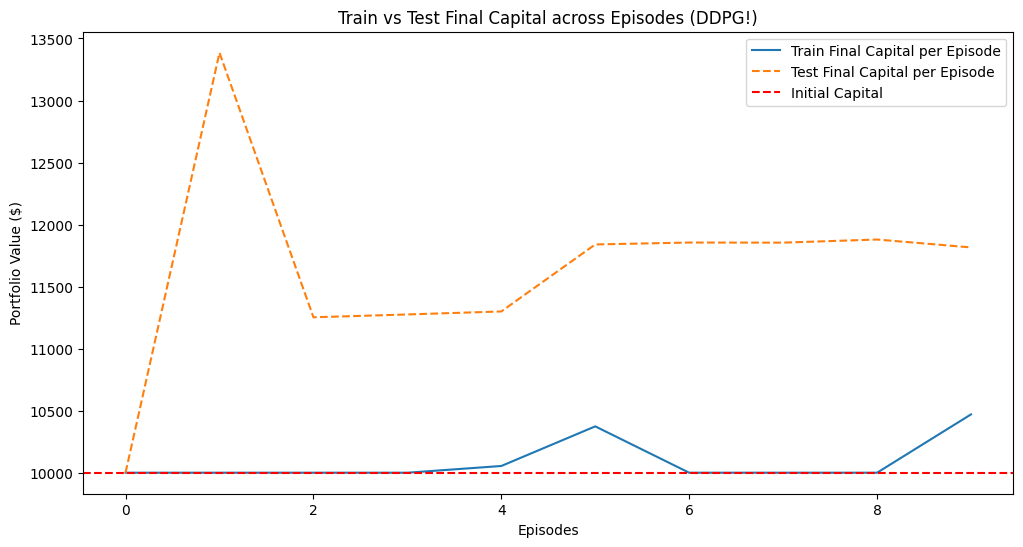

In [ ]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

features = ['Open','High','Low','Close','MA7','MA21','daily_sentiment_score'] # Ensure features are defined
scaler = MinMaxScaler() # Ensure scaler is defined or imported and instantiated
states = scaler.fit_transform(df[features])
prices = df['Close'].values

# ==================================================
# ⚡️ PARAMETERS
# ==================================================
train_split = int(0.8 * len(df))
train_states = states[:train_split]
train_prices = prices[:train_split]
test_states = states[train_split:]
test_prices = prices[train_split:]

state_dim = train_states.shape[1]
action_dim = 1           # Action is CONTINUOUS [-1,1]
initial_capital = 10000
transaction_cost = 0.001
n_episodes = 10
batch_size = 32
target_update_freq = 5
train_interval = 1
window_size = 10
gamma = 0.99
tau = 0.005              # Polyak averaging rate
actor_lr = 0.0001
critic_lr = 0.001


# ==================================================
# ⚡️ UTILITY FUNCTION TO CREATE SEQUENCES
# ==================================================
def create_sequences(data, window_size):
    """ Returns array of shape (n_samples, window_size, state_dim) """
    seq = []
    for i in range(len(data) - window_size + 1):
        seq.append(data[i:i + window_size])
    return np.array(seq)

train_states_seq = create_sequences(train_states, window_size)
train_prices_seq = train_prices[window_size-1:]
test_states_seq = create_sequences(test_states, window_size)
test_prices_seq = test_prices[window_size-1:]


# ==================================================
# ⚡️ BUILD ACTOR MODEL
# ==================================================
def build_actor(window_size, state_dim, action_dim, hidden_dim=64, n_hidden_layers=2, dropout_rate=0.1):
    """Actor Model as per DDPG paper."""
    i = Input(shape=(window_size, state_dim))
    x = LSTM(hidden_dim, return_sequences=False)(i)

    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    a = Dense(action_dim, activation='tanh')(x)  # Output [-1,1]
    return Model(i, a)


# ==================================================
# ⚡️ BUILD CRITIC MODEL
# ==================================================
def build_critic(window_size, state_dim, action_dim, hidden_dim=64, n_hidden_layers=2, dropout_rate=0.1):
    """Critic Model as per DDPG paper."""
    state_in = Input(shape=(window_size, state_dim))
    action_in = Input(shape=(action_dim,))
    x = LSTM(hidden_dim, return_sequences=False)(state_in)

    concat = tf.keras.layers.Concatenate()([x, action_in])

    for _ in range(n_hidden_layers):
        concat = Dense(hidden_dim, activation='relu')(concat)
        concat = Dropout(dropout_rate)(concat)

    q_value = Dense(1, activation='linear')(concat)
    return Model([state_in, action_in], q_value)

# ==================================================
# ⚡️ REPLAY BUFFER
# ==================================================
class ReplayBuffer:
    """Experience Replay Buffer for DDPG."""
    def __init__(self, window_size, state_dim, action_dim, size=10000):
        self.obs1_buf = np.zeros([size, window_size, state_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, window_size, state_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, action_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        # Initialize done_buf with float32
        self.done_buf = np.zeros(size, dtype=np.float32)  # Changed from uint8

        self.ptr = 0
        self.size = 0
        self.max_size = size

    def store(self, obs, act, rew, next_obs, done):
        """Store experience tuple"""
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        # Ensure done is stored as float32
        self.done_buf[self.ptr] = float(done)  # Ensure boolean is stored as float
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        """Sample batch of experiences"""
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            "s": self.obs1_buf[idxs],
            "s2": self.obs2_buf[idxs],
            "a": self.acts_buf[idxs],
            "r": self.rews_buf[idxs],
            # done_buf is already float32, no need to convert here
            "d": self.done_buf[idxs]
        }

# Rest of the code remains the same
# ==================================================
# ⚡️ DDPG AGENT DEFINITION
# ==================================================
class DDPGAgent:
    """DDPG Agent - Actor-Critic Architecture with Target Networks and Polyak Averaging."""
    def __init__(self, window_size, state_dim, action_dim,
                 gamma=0.99, tau=0.005,
                 actor_lr=1e-4, critic_lr=1e-3,
                 batch_size=32):

        self.window_size = window_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Actor and Critic Models
        self.actor = build_actor(window_size, state_dim, action_dim)
        self.critic = build_critic(window_size, state_dim, action_dim)

        # Target Networks
        self.target_actor = build_actor(window_size, state_dim, action_dim)
        self.target_critic = build_critic(window_size, state_dim, action_dim)

        # Optimizers
        self.actor_optimizer = Adam(learning_rate=actor_lr)
        self.critic_optimizer = Adam(learning_rate=critic_lr)

        # Initial Target Weights
        self.update_target_weights(1.0)

    def update_target_weights(self, tau=None):
        """Soft Update Target Networks using Polyak Averaging"""
        if tau is None:
            tau = self.tau

        for target_w, w in zip(self.target_actor.weights, self.actor.weights):
            target_w.assign(tau * w + (1-tau) * target_w)

        for target_w, w in zip(self.target_critic.weights, self.critic.weights):
            target_w.assign(tau * w + (1-tau) * target_w)

    def act(self, state, noise_scale=0.1):
        """Action Selection with Exploration"""
        # Ensure input state is a tensor for prediction
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        action = self.actor.predict(state, verbose=0)
        noise = noise_scale * np.random.randn(*action.shape)
        return np.clip(action + noise, -1, 1)

    # Use tf.function for efficiency in training step
    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        """Single training step for Actor-Critic"""
        # Convert numpy arrays to tensors within the tf.function scope
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)


        # Critic Update
        with tf.GradientTape() as tape:
            next_actions = self.target_actor(next_states)
            target_q_values = self.target_critic([next_states, next_actions])
            target_values = rewards + (1 - dones) * self.gamma * target_q_values

            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean(tf.square(q_values - target_values))

        critic_grads = tape.gradient(critic_loss, self.critic.trainable_weights)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        # Actor Update
        with tf.GradientTape() as tape:
            actions_for_states = self.actor(states)
            # Pass actions_for_states (tensor) directly to the critic
            actor_loss = -tf.reduce_mean(self.critic([states, actions_for_states]))

        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_weights))

        # Target Networks Update
        self.update_target_weights()


    def train(self, replay_buffer):
        """Train Actor-Critic from Replay Buffer"""
        if replay_buffer.size < self.batch_size:
            return

        batch = replay_buffer.sample_batch(self.batch_size)

        states = batch["s"]
        next_states = batch["s2"]
        actions = batch["a"]
        rewards = batch["r"].reshape(-1, 1)
        dones = batch["d"].reshape(-1, 1)

        # Call the tf.function wrapped training step
        self.train_step(states, actions, rewards, next_states, dones)


# ==================================================
# ⚡️ TRAINING LOOP
# ==================================================
os.makedirs('./models', exist_ok=True)

agent = DDPGAgent(window_size, state_dim, action_dim,
                  gamma, tau, actor_lr, critic_lr, batch_size)

memory = ReplayBuffer(window_size, state_dim, action_dim)

portfolio_values_train = []
all_rewards_train = []
portfolio_values_test = []
all_rewards_test = []
best_test_score = -np.inf
best_model_weights = None
max_episode_len = min(700, len(train_states_seq))

for episode in range(n_episodes):
    balance = initial_capital
    holdings = 0
    total_rewards = 0

    # Randomly pick training episode range
    start = np.random.randint(0, len(train_states_seq) - max_episode_len)
    end = start + max_episode_len
    episode_states = train_states_seq[start:end]
    episode_prices = train_prices_seq[start:end]

    # ==============================
    # ⚡️ Training Loop
    # ==============================
    for t in range(len(episode_states) - 1):
        # Reshape state for the actor's predict method if it's not already (batch, window, features)
        # actor.predict expects a batch dimension, even for a single sample
        state = episode_states[t].reshape(1, window_size, state_dim)
        next_state = episode_states[t + 1].reshape(1, window_size, state_dim)
        price = episode_prices[t]
        next_price = episode_prices[t + 1]

        # Action: fraction of portfolio to buy/sell
        action = agent.act(state)
        quantity = (balance // price) * action[0, 0]
        # Ensure quantity is within reasonable bounds based on current balance/holdings
        # You might need a more sophisticated way to handle this clipping depending on your strategy
        max_buy_quantity = balance // price
        max_sell_quantity = holdings
        quantity = np.clip(quantity, -max_sell_quantity, max_buy_quantity)


        prev_value = balance + holdings * price
        cost = quantity * price * (1 + transaction_cost)

        # Apply the action
        if quantity > 0: # Buying
             # Only proceed if we can actually afford the quantity + transaction cost
            if balance >= quantity * price * (1 + transaction_cost):
                balance -= quantity * price * (1 + transaction_cost)
                holdings += quantity
            else:
                 # If not enough balance, buy as much as possible
                 affordable_quantity = balance // (price * (1 + transaction_cost))
                 if affordable_quantity > 0:
                    balance -= affordable_quantity * price * (1 + transaction_cost)
                    holdings += affordable_quantity


        elif quantity < 0: # Selling
            # Only proceed if we have enough holdings
            if holdings >= -quantity:
                revenue = -quantity * price * (1 - transaction_cost)
                balance += revenue
                holdings += quantity # quantity is negative
            else:
                 # If not enough holdings, sell all holdings
                 revenue = holdings * price * (1 - transaction_cost)
                 balance += revenue
                 holdings = 0 # Sold all holdings


        new_value = balance + holdings * next_price
        # Reward calculation might need normalization or different scaling
        reward = (new_value - prev_value) # Using raw difference as in previous code

        # Handle done condition
        done = (t == len(episode_states) - 2)

        # Store experience
        # Note: Replay buffer stores the original (window_size, state_dim) shape
        memory.store(episode_states[t], action[0], reward, episode_states[t + 1], done) # Pass action[0] to remove batch dim

        total_rewards += reward

        # Train the agent
        # Train at every step or every N steps as needed
        agent.train(memory)


    final_episode_value = balance + holdings * episode_prices[-1]
    portfolio_values_train.append(final_episode_value)
    all_rewards_train.append(total_rewards)

    # ==============================
    # ⚡️ Testing Loop
    # ==============================
    test_balance = initial_capital
    test_holdings = 0
    test_total_rewards = 0
    for t in range(len(test_states_seq) - 1):
        state = test_states_seq[t].reshape(1, window_size, state_dim)
        action = agent.actor.predict(state, verbose=0)  # Pure Exploitation
        price = test_prices_seq[t]
        next_price = test_prices_seq[t + 1]

        # Action: fraction of portfolio to buy/sell
        # The interpretation of the continuous action needs to be consistent
        # with the training loop. Assuming it represents a fraction of current value
        # or available funds/holdings. Let's use a similar logic to the training buy/sell.
        # For simplicity, interpret action[0,0] as proportion of available balance to buy
        # or proportion of current holdings to sell.
        quantity_proportion = action[0, 0]

        prev_value = test_balance + test_holdings * price

        if quantity_proportion > 0: # Buy
            # Buy based on quantity_proportion of available balance
            quantity_to_buy = (test_balance / price) * quantity_proportion
            cost = quantity_to_buy * price * (1 + transaction_cost)
            if cost <= test_balance:
                 test_balance -= cost
                 test_holdings += quantity_to_buy
            else:
                 # Buy as much as possible if not enough balance
                 affordable_quantity = test_balance // (price * (1 + transaction_cost))
                 if affordable_quantity > 0:
                    test_balance -= affordable_quantity * price * (1 + transaction_cost)
                    test_holdings += affordable_quantity

        elif quantity_proportion < 0: # Sell
            # Sell based on |quantity_proportion| of current holdings
            quantity_to_sell = test_holdings * abs(quantity_proportion)
            if quantity_to_sell <= test_holdings:
                 revenue = quantity_to_sell * price * (1 - transaction_cost)
                 test_balance += revenue
                 test_holdings -= quantity_to_sell
            else:
                 # Sell all holdings if trying to sell more than available
                 revenue = test_holdings * price * (1 - transaction_cost)
                 test_balance += revenue
                 test_holdings = 0


        test_new_value = test_balance + test_holdings * next_price
        test_total_rewards += (test_new_value - prev_value) # Using raw difference for consistency

    final_test_value = test_balance + test_holdings * test_prices_seq[-1]
    portfolio_values_test.append(final_test_value)
    all_rewards_test.append(test_total_rewards)

    # ==============================
    # ⚡️ LOG RESULTS
    # ==============================
    print(f"Episode {episode + 1}/{n_episodes} | "
          f"Train Final: ${final_episode_value:.2f}, Test Final: ${final_test_value:.2f} | "
          f"Train Reward: {total_rewards:.4f}, Test Reward: {test_total_rewards:.4f}")

    # Save Best Model
    if final_test_value > best_test_score:
        best_test_score = final_test_value
        best_model_weights = (agent.actor.get_weights(), agent.critic.get_weights())
        agent.actor.save('./models/best_actor_model.h5')
        agent.critic.save('./models/best_critic_model.h5')
        print(f"✅ New Best Model Saved with Final Test Value: ${final_test_value:.2f}")


# ==================================================
# ⚡️ EVALUATION METRICS
# ==================================================
train_cumulative_return = (np.mean(portfolio_values_train) / initial_capital) - 1
test_cumulative_return = (np.mean(portfolio_values_test) / initial_capital) - 1
train_average_return = np.mean(portfolio_values_train) - initial_capital
test_average_return = np.mean(portfolio_values_test) - initial_capital
train_volatility = np.std(portfolio_values_train)
test_volatility = np.std(portfolio_values_test)

train_sharpe_ratio = train_average_return / (train_volatility + 1e-9)
test_sharpe_ratio = test_average_return / (test_volatility + 1e-9)


# ==================================================
# ⚡️ PRINT METRICS
# ==================================================
print("\n📊 Final Results after Training DDPG Agent:\n")
print(f"Train Final Capital (average): ${np.mean(portfolio_values_train):.2f}")
print(f"Train Cumulative Return      : {train_cumulative_return * 100:.2f}%")
print(f"Train Average Profit/Loss    : ${train_average_return:.2f}")
print(f"Train Sharpe Ratio           : {train_sharpe_ratio:.4f}")

print(f"Test Final Capital (average): ${np.mean(portfolio_values_test):.2f}")
print(f"Test Cumulative Return       : {test_cumulative_return * 100:.2f}%")
print(f"Test Average Profit/Loss     : ${test_average_return:.2f}")
print(f"Test Sharpe Ratio            : {test_sharpe_ratio:.4f}")

# ==================================================
# 📈 PLOT RESULTS
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_train, label="Train Final Capital per Episode")
plt.plot(portfolio_values_test, label="Test Final Capital per Episode", linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Portfolio Value ($)")
plt.title("Train vs Test Final Capital across Episodes (DDPG!)")
plt.show()